# L2 FWI Example
We will solve this problem using the following steps:
1. Read the true and starting models from binary files coarsen them and visualize
2. Build up a small local compute cluster and load packages onto the compute cluster
3. Build F, the forward modeling operator
4. Use F and the true model to create a synthetic data-set
5. Build the gradient and cost functions
6. Do the FWI using optim.jl

In [2]:
using PyPlot, Distributed

### 1. Read the true and starting models from binary files coarsen them and visualize

In [3]:
v = read!("../02_marmousi_model_setup/marmousi_vp_20m_176x851.bin", Array{Float32}(undef, 176,851));
vₒ= read!("../02_marmousi_model_setup/marmousi_vp_smooth_20m_176x851.bin", Array{Float32}(undef, 176,851));

In [4]:
v = v[1:2:end,1:2:end]
vₒ = vₒ[1:2:end,1:2:end];

In [5]:
dz,dx = 40.0,40.0
nz,nx = size(v)
@show dz,dx
@show nz,nx;

(dz, dx) = (40.0, 40.0)
(nz, nx) = (88, 426)


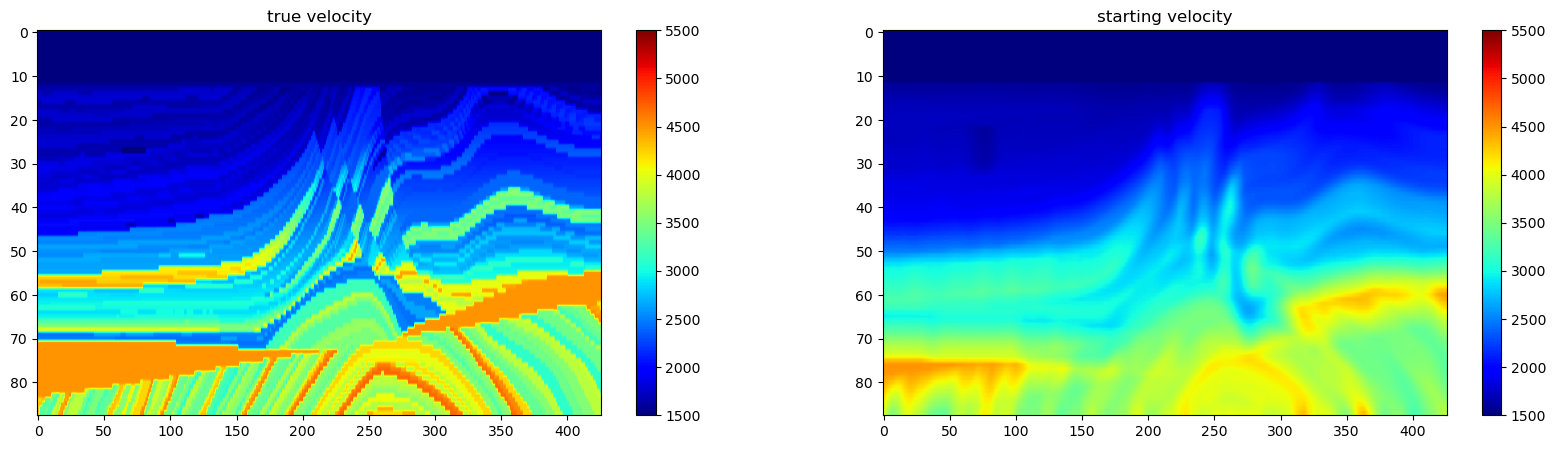

In [6]:
figure(figsize=(20,5))
subplot(121);imshow(v,aspect="auto",cmap="jet");colorbar();clim(1500,5500);title("true velocity")
subplot(122);imshow(vₒ,aspect="auto",cmap="jet");colorbar();clim(1500,5500);title("starting velocity");

### 2. Build up a small local compute cluster and load packages onto the compute cluster

In [7]:
addprocs(2);

In [8]:
@everywhere using Distributed, DistributedArrays, DistributedJets, Jets, JetPack, WaveFD, JetPackWaveFD, LinearAlgebra, LineSearches, Optim, Random

### 3. Build F, the forward modeling operator

8 shot locations (only using 8 because we are using our local machines to run the FWI)

In [9]:
sx = (0.0:dx*28:(nx-1)*dx)
nshots = length(sx)
@show nshots;

nshots = 16


In [10]:
@everywhere function makeF(i,sx)
    nz,nx,dz,dx = 88,426,40.0,40.0    
    JopNlProp2DAcoIsoDenQ_DEO2_FDTD(;
        b = ones(Float32,nz,nx),
        nthreads = div(Sys.CPU_THREADS,2),
        ntrec = 801,
        dtrec = 0.012,
        dtmod = 0.004,
        dz = dz,
        dx = dx,
        wavelet = WaveletCausalRicker(f=2.0),
        sx = sx[i],
        sz = dz,
        rx = dx*[0:1:nx-1;],
        rz = 2*dz*ones(length(0:1:nx-1)),
        comptype = UInt32,
        srcfieldfile = "/home/cvx/scratch/field-$i.$(randstring()).bin",
        reportinterval=0)
end

In [11]:
F = @blockop DArray(I->[makeF(i,sx) for i in I[1], j in I[2]], (nshots,1))

&quot;Jet nonlinear operator, (88, 426) → (5459616,)&quot;

### 4. Use F and the true model to create a synthetic data-set

In [12]:
# This may take awhile if running on a single node

@time begin
    d = F*v;
end

2520.454140 seconds (11.75 M allocations: 591.719 MiB, 0.01% gc time)


5459616-element DBArray{Float32,Jets.BlockArray{Float32,Array{Float32,2}},Array{Jets.BlockArray{Float32,Array{Float32,2}},1}}:
  0.0
 -0.00075593777
 -0.00910305
 -0.032901227
 -0.071538985
 -0.1227543
 -0.19494824
 -0.30592355
 -0.47437468
 -0.7212713
 -1.0785779
 -1.5922014
 -2.3204203
  ⋮
  0.00039751607
  0.002456325
  0.004036824
  0.005219935
  0.0060998388
  0.006755921
  0.007258764
  0.0076879426
  0.008125113
  0.008638432
  0.00928312
  0.010101245

Plot shot gathers from the in-memory distributed array

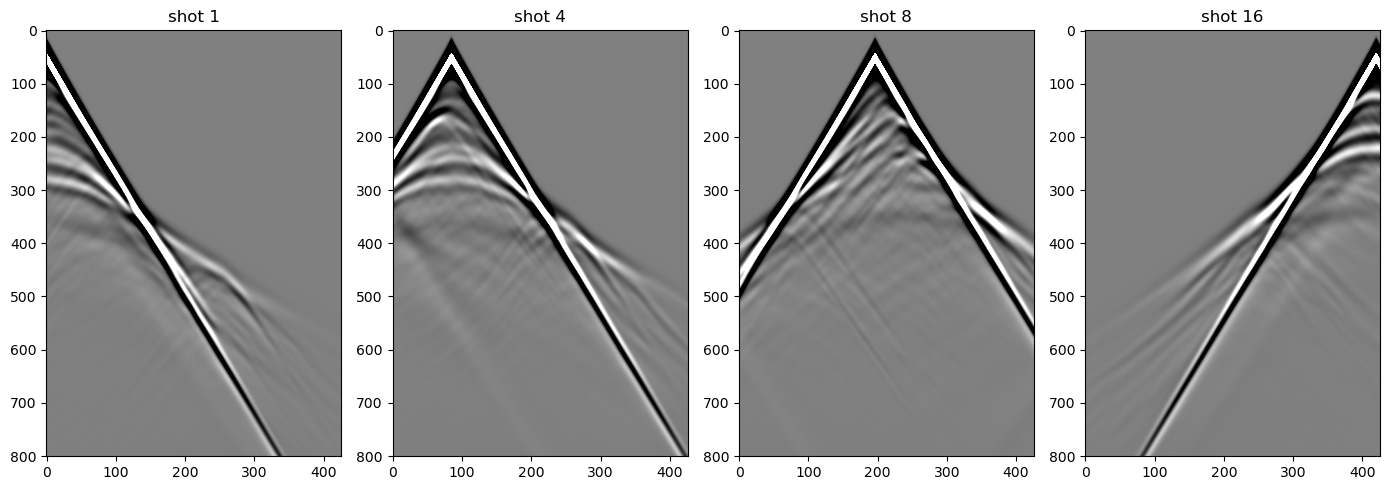

In [13]:
ishots = [1, 4, 8, 16]
figure(figsize=(14,5))
for (iplot,ishot) in enumerate(ishots)
    subplot(1,4,iplot);imshow(getblock(d,ishot)[:,:,1],cmap="gray",aspect="auto",clim=[-10,10]);title("shot $(ishot)");
end
tight_layout()

### 5. Build the gradient and cost functions

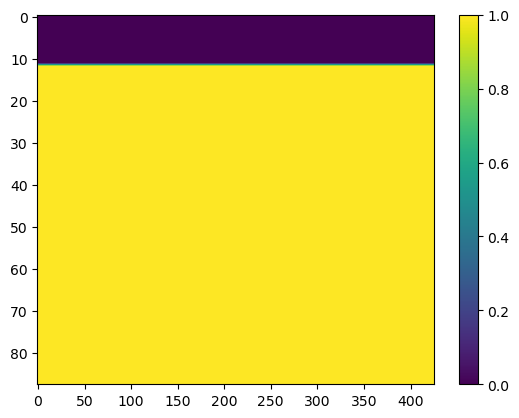

In [14]:
#build water bottom mask for gradient
wb_mask = ones(Float32,size(v))
wb_mask[v.==1500.0].=0.0;
imshow(wb_mask,aspect="auto");colorbar();

In [15]:
function gradient!(G,F,v,dobs,p,wb_mask)
    J = jacobian(F,v)
    s = srcillum(J)
    s .= ((s ./ maximum(s)).^2) .+ 1e-8
    R = JopDiagonal((1 ./ s).^2)
    G .= R' ∘ J' * (dobs - F*v)
    G .*= wb_mask #mute water column
    if p.gscale == 0.0
       p.gscale = 10 ./ maximum(G) #make a scalar from first gradient (then apply to all future gradients)
    end
    G .*= p.gscale
    close(F) #delete local files
end
mutable struct FwiPar
   gscale
end
p = FwiPar(0.0)
g!(G,x) = gradient!(G,F,x,d,p,wb_mask)

g! (generic function with 1 method)

In [16]:
grad = zeros(Float32,size(v))
g!(grad,vₒ)

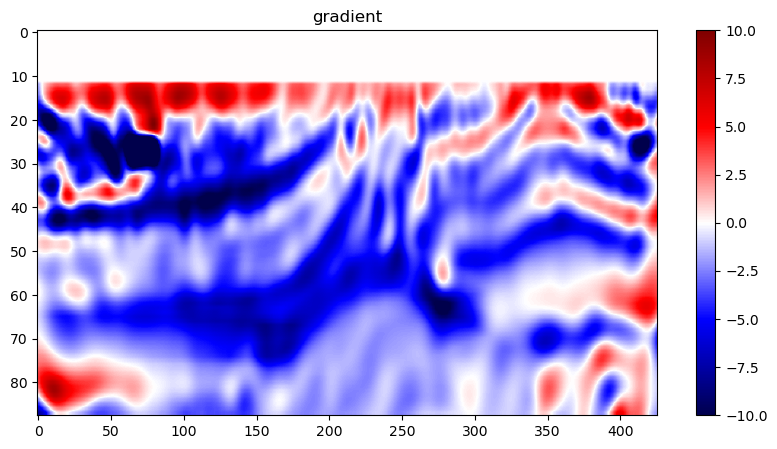

In [17]:
figure(figsize=(10,5))
imshow(grad,aspect="auto",cmap="seismic");colorbar();clim(-10,10);title("gradient");

In [18]:
diffnorm(x, y) = sqrt(mapreduce(i->(x[i] - y[i])^2, +, 1:length(x)))
function cost(x,F,d)
    dm = F*x
    phi = diffnorm(d, dm)
    return phi
end
f(x) = cost(x,F,d)

f (generic function with 1 method)

In [19]:
@info "initial cost $(f(vₒ))";

┌ Info: initial cost 1962.7332
└ @ Main In[19]:1


### 6. Do the FWI using optim.jl

In [20]:
solver = LBFGS(m = 20, alphaguess = LineSearches.InitialQuadratic(), linesearch = LineSearches.MoreThuente());

In [21]:
function mycallback(state::OptimizationState)
    @info "iter=$(state.iteration), cost=$(state.value), |grad|=$(state.g_norm)"
    false
end
mycallback(trace::OptimizationTrace) = mycallback(trace[end]);

In [ ]:
p = FwiPar(0.0)
redirect_stdout(open("/dev/null","w")) # otherwise the models are printed to stdout at every iteration
result = optimize(f, g!, vₒ, solver,
    Optim.Options(
        iterations = 100,
        show_trace = true,
        store_trace = true,
        show_every = 1,
        extended_trace = true,
        allow_f_increases = false,
        callback = mycallback))

In [ ]:
vfwi = Optim.minimizer(result) # optimal solution
ϕ = Optim.f_trace(result)   # cost vs iteration
m = Optim.x_trace(result);   # model vs iteration

In [ ]:
rmprocs(workers())

In [ ]:
figure(figsize=(20,5))
subplot(121);imshow(v,aspect="auto",cmap="jet");colorbar();clim(1500,4500);title("true velocity")
subplot(122);imshow(vfwi,aspect="auto",cmap="jet");colorbar();clim(1500,4500);title("fwi velocity");

In [ ]:
plot(ϕ)